In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import pandas as pd
import numpy as np
import sys

from urllib.request import urlopen
from urllib.parse import unquote, urlparse

from zipfile import ZipFile
import tarfile
import shutil





# 2. Imports and global variables

In [8]:
import copy
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import GroupKFold
from torch.utils.data import Dataset
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange
from time import time
from sklearn.model_selection import train_test_split

In [4]:
!pip install ucimlrepo

In [5]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
forest_fires = fetch_ucirepo(id=162)

# data (as pandas dataframes)
X = forest_fires.data.features
Y = forest_fires.data.targets
df = pd.concat([X, Y], axis=1)

In [6]:
# Define mappings for months and days
month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

day_mapping = {
    'sun': 1, 'mon': 2, 'tue': 3, 'wed': 4, 'thu': 5, 'fri': 6, 'sat': 7
}

# Map months and days in the DataFrame
df['month'] = df['month'].map(month_mapping)
df['day'] = df['day'].map(day_mapping)




In [9]:
y=df['area']
x=df.drop(columns=['area'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# 3. Dataset interface

In [11]:
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,6,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,10,3,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,10,7,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,3,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,3,1,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,8,1,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,8,1,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,8,1,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,8,7,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


# Neural Net model and Quantile loss

In [12]:
class QuantModel(nn.Module):
    def __init__(self, in_tabular_features=12, out_quantiles=1):
        super(QuantModel, self).__init__()
        self.fc1 = nn.Linear(in_tabular_features, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, out_quantiles)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def quantile_loss(preds, target, quantiles):
    assert not target.requires_grad
    assert preds.size(0) == target.size(0)
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - preds[:, i]
        losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(1))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming you have your dataset loaded into X and y numpy arrays
# X should be a numpy array of shape (num_samples, num_features)
# y should be a numpy array of shape (num_samples,)


# Define your QuantModel and quantile_loss function

y = df['area']
X = df.drop(columns=['area'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Creating DataLoader for train and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=2)

# Define the list of models, one for each quantile
num_models = 29  # Number of quantiles
models = [QuantModel() for _ in range(num_models)]

# Define the list of optimizers, one for each model
optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

# Training the models
num_epochs = 20
quantiles = [(i+1)/30 for i in range(num_models)]

train_losses = [[] for _ in range(num_models)]  # List to store train losses for each quantile
test_losses = [[] for _ in range(num_models)]   # List to store test losses for each quantile

for epoch in range(num_epochs):
    for model, optimizer, quantile in zip(models, optimizers, quantiles):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = quantile_loss(outputs, targets, [quantile])
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses[quantiles.index(quantile)].append(epoch_loss)
        if(epoch%5==0):

          print(f"Epoch [{epoch+1}/{num_epochs}], Quantile: {quantile}, Train Loss: {epoch_loss:.4f}")

# Evaluate the models
for model, quantile in zip(models, quantiles):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = quantile_loss(outputs, targets, [quantile])
            test_loss += loss.item() * inputs.size(0)
    avg_test_loss = test_loss / len(test_loader.dataset)
    test_losses[quantiles.index(quantile)].append(avg_test_loss)
    print(f"Quantile: {quantile}, Average Test Loss: {avg_test_loss:.4f}")

print("Average Test Losses:")
for quantile, avg_loss in zip(quantiles, test_losses):
    print(f"Quantile: {quantile}, Average Test Loss: {np.mean(avg_loss):.4f}")

Epoch [1/20], Quantile: 0.03333333333333333, Train Loss: 0.8790
Epoch [1/20], Quantile: 0.06666666666666667, Train Loss: 1.2944
Epoch [1/20], Quantile: 0.1, Train Loss: 1.7787
Epoch [1/20], Quantile: 0.13333333333333333, Train Loss: 1.9518
Epoch [1/20], Quantile: 0.16666666666666666, Train Loss: 2.7646
Epoch [1/20], Quantile: 0.2, Train Loss: 3.1705
Epoch [1/20], Quantile: 0.23333333333333334, Train Loss: 3.6310
Epoch [1/20], Quantile: 0.26666666666666666, Train Loss: 3.9724
Epoch [1/20], Quantile: 0.3, Train Loss: 4.2040
Epoch [1/20], Quantile: 0.3333333333333333, Train Loss: 4.5975
Epoch [1/20], Quantile: 0.36666666666666664, Train Loss: 5.1274
Epoch [1/20], Quantile: 0.4, Train Loss: 5.3872
Epoch [1/20], Quantile: 0.43333333333333335, Train Loss: 6.0020
Epoch [1/20], Quantile: 0.4666666666666667, Train Loss: 6.2824
Epoch [1/20], Quantile: 0.5, Train Loss: 6.3319
Epoch [1/20], Quantile: 0.5333333333333333, Train Loss: 6.8789
Epoch [1/20], Quantile: 0.5666666666666667, Train Loss: 7.3

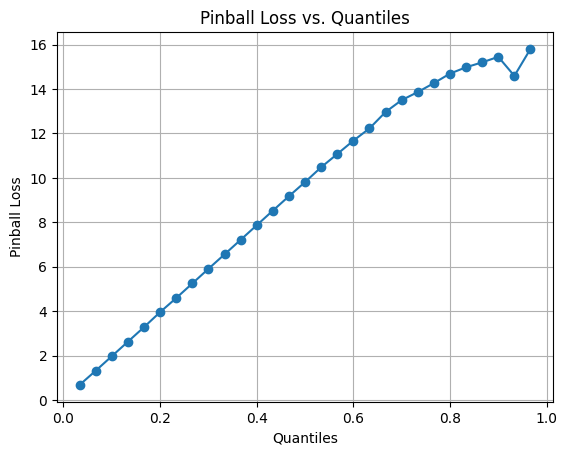

In [37]:
plt.plot(quantiles, test_losses, marker='o')
plt.xlabel('Quantiles')
plt.ylabel('Pinball Loss')
plt.title('Pinball Loss vs. Quantiles')
plt.grid(True)
plt.show()
